# Intuition
Evaluating Player Vectors is challenging as no objective ground truth exists for characterizing playing style.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.decomposition import NMF

from src.playervectors import PlayerVectors
from src.ExtractData import (
    ExtractCoordinates, 
    ExtractPlayers, 
    ExtractTeams, 
    ExtractMinutesPlayed, 
    ExtractGoalkeepers 
)

## Load: Players

In [2]:
df_players = pd.read_csv('event_streams/players.csv')
df_playerank = pd.read_csv('event_streams/playerank.csv')

# Extract Player Information
# Mapping {player_id -> [list of selected attributes]}
players = ExtractPlayers(df=df_players, wy_id='wyId', attributes=['firstName', 'lastName', 'currentTeamId'])

# Extract Goalkeepers
# Mapping player_id -> None
keepers = ExtractGoalkeepers(df_players, wy_code='name', keeper_str='Goalkeeper')

# Extract played minutes
# Mapping {player_id -> minutes}
minutes_played = ExtractMinutesPlayed(df=df_playerank, column_player='playerId', column_minutes='minutesPlayed')

## Load: Event Streams

In [3]:
df_events = pd.read_csv('event_streams/actions.csv')

# Normalize playing direction
df_events['start_x'] = 100 - df_events['start_x']
df_events['start_y'] = 100 - df_events['start_y']

# Extract relevant action coordinates
# {action -> {playerID -> ([list of x coordinates], [list of y coordinates])}}
coordinates = ExtractCoordinates(df=df_events,
                                 column_player_id='player_id',
                                 column_event_name='type_name',
                                 column_x='start_x',
                                 column_y='start_y',
                                 actions=['pass', 'cross', 'dribble', 'shot'])

# Fine tuning: Remove Goalkeepers
for action, player_coordinates in coordinates.items():
    # Create a list of player IDs to be removed
    players_to_remove = [player_id for player_id in player_coordinates if player_id in keepers]
    
    # Remove players from the action dictionary
    for player_id in players_to_remove:
        del coordinates[action][player_id]

#### Select Relevant Actions with respect to thier x,y coordinates

##### How does ExtractCoordinates work?

```python
>>> df
       playerID action   x   y
    0         1   pass  55  45
    1         1   pass  50  40
    2         1   shot  53  43
    3         1   shot  54  44
    4         2   pass  43  33
    5         2  cross  43  23
    6         2  cross  42  32
    7         3   pass  17  57
    8         3   pass  10  50
    9         3   pass  15  55
    
    >>> action_coordinates = ExtractCoordinates(df=df,
    ...                                         column_player_id='playerID',
    ...                                         column_event_name='action',
    ...                                         column_x='x',
    ...                                         column_y='y',
    ...                                         actions=['pass', 'shot', 'cross'])
    >>> action_coordinates
    {'pass': {1: ([55, 50], [45, 40]), 2: ([43], [33]), 3: ([17, 10, 15], [57, 50, 55])},
     'shot': {1: ([53, 54], [43, 44])},
     'cross': {2: ([43, 42], [23, 32])}}
```

## Load: Teams

In [4]:
df_teams = pd.read_csv('event_streams/teams.csv')

# Extracting Team Information
# Mapping {teamID -> [selected attributes e.g. TeamName, City, ...]}
teams = ExtractTeams(df=df_teams, wy_id='wyId', attributes=['name'])

# Mapping {teamID -> [list of playerIDs]}
teamID_to_playerIDs = {}

# Mapping {playerID -> Player Name}
playersID_to_name = {}

for playerID, attributes in players.items():
    first, last, teamID = attributes[0], str(attributes[1]), str(attributes[2])
    
    if teamID not in teamID_to_playerIDs:
        teamID_to_playerIDs[teamID] = [playerID]
    else:
        teamID_to_playerIDs[teamID].append(playerID)
    
    if playerID not in playersID_to_name:
        playersID_to_name[playerID] = f'{first} {last}'

## Building Player Vectors

### 1. Selecting Relevant Action Types
Let $k_t$ be the number of principal components chosen to compress heatmaps of action type $t$.

According to the paper, $k_t$ with $t \in \{\text{shot}, \text{cross}, \text{dribble}, \text{pass}\}$ with corresponding components $\{4, 4, 5, 5\}$ is the minimal number of components needed to explain
70% of the variance in the heatmaps of action type $t$.

This parameter setting
was empirically found to work well because of the high variability of players
positions in their actions (see Challenge 1 in Section 2 in the paper).

Ignoring 30% of the variance allows to summarize a player’s playstyle only by his dominant regions
on the field rather than model every position on the field he ever occupied.

### 2. Constructing Heatmaps

* 2.1 Counting

* 2.2 Normalizing

* 3.3 Smoothing

### 3. Compressing Heatmaps to Vectors

* 3.1 Reshaping

* 3.2 Construct the matrix M

* 3.3 Compress matrix M by applying non-negative matrix factorization (NMF)

### 4. Assembling Player Vectors

In [5]:
# Creating a PlayerVectors object
PVs = PlayerVectors(shape=(50, 50),
                    sigma=4.0,
                    actions=['shot', 'cross', 'dribble', 'pass'],
                    components=[4, 4, 5, 5])

PVs.fit(coordinates=coordinates,
        minutes_played=minutes_played,
        player_names=playersID_to_name,
        verbose=True)

Action: shot	Shape of M: (2500, 2798)	Shape of W: (2500, 4)	Shape of H: (4, 2798)
Action: cross	Shape of M: (2500, 2798)	Shape of W: (2500, 4)	Shape of H: (4, 2798)
Action: dribble	Shape of M: (2500, 2798)	Shape of W: (2500, 5)	Shape of H: (5, 2798)
Action: pass	Shape of M: (2500, 2798)	Shape of W: (2500, 5)	Shape of H: (5, 2798)


## 18 Components of our Player Vectors 
The 18 components of our player vectors constructed by compressing heatmaps
of shots (1-4), crosses (5-8), dribbles (9-13), and passes (14-18) with non-negative
matrix factorization

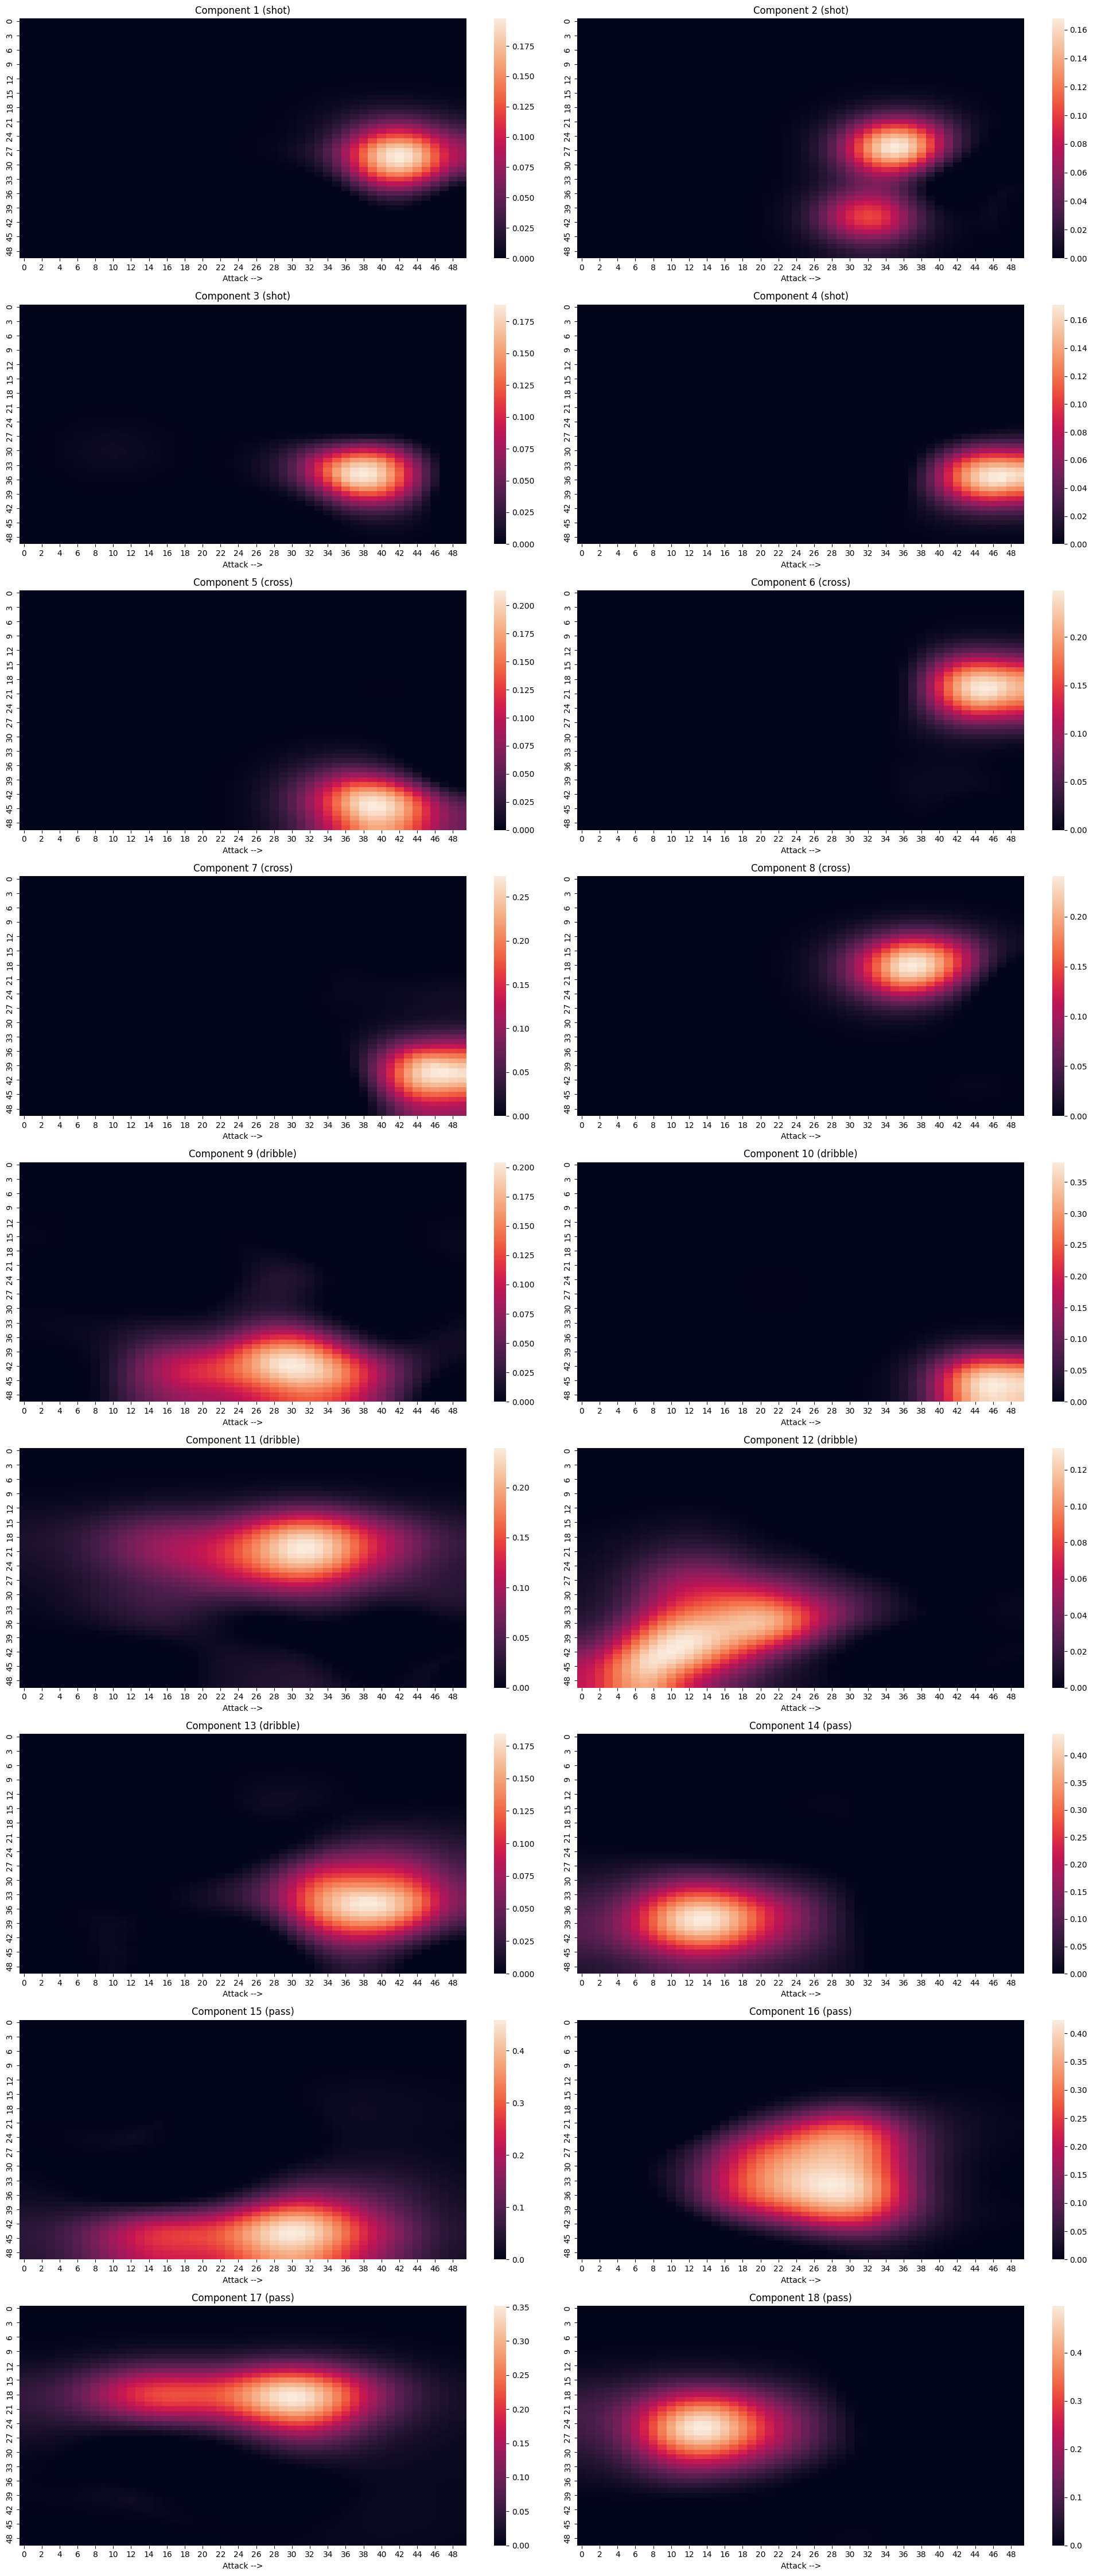

In [6]:
PVs.plot_principle_components(figsize=(20, 45))
plt.show()

### Interpretation

* Component (1): Close shot

* Component (2): Far shot

* Component (3): Far shot right

* Component (4): Close shot right

* Component (5): R. corner cross

* Component (6): L. backline cross

* Component (7): R. flank cross

* Component (8): L. far backline cross

* Component (9): Center dribble (front)

* Component (10): L. flank dribble

* Component (11): R. corner dribble

* Component (12): Center dribble (back)

* Component (13): L. flank dribble

* Component (14): Center pass

* Component (15): Right flank pass

* Component (16): Right back pass

* Component (17): Left flank pass

* Component (17): Center pass (back)

## Boxplot Weight Distribution

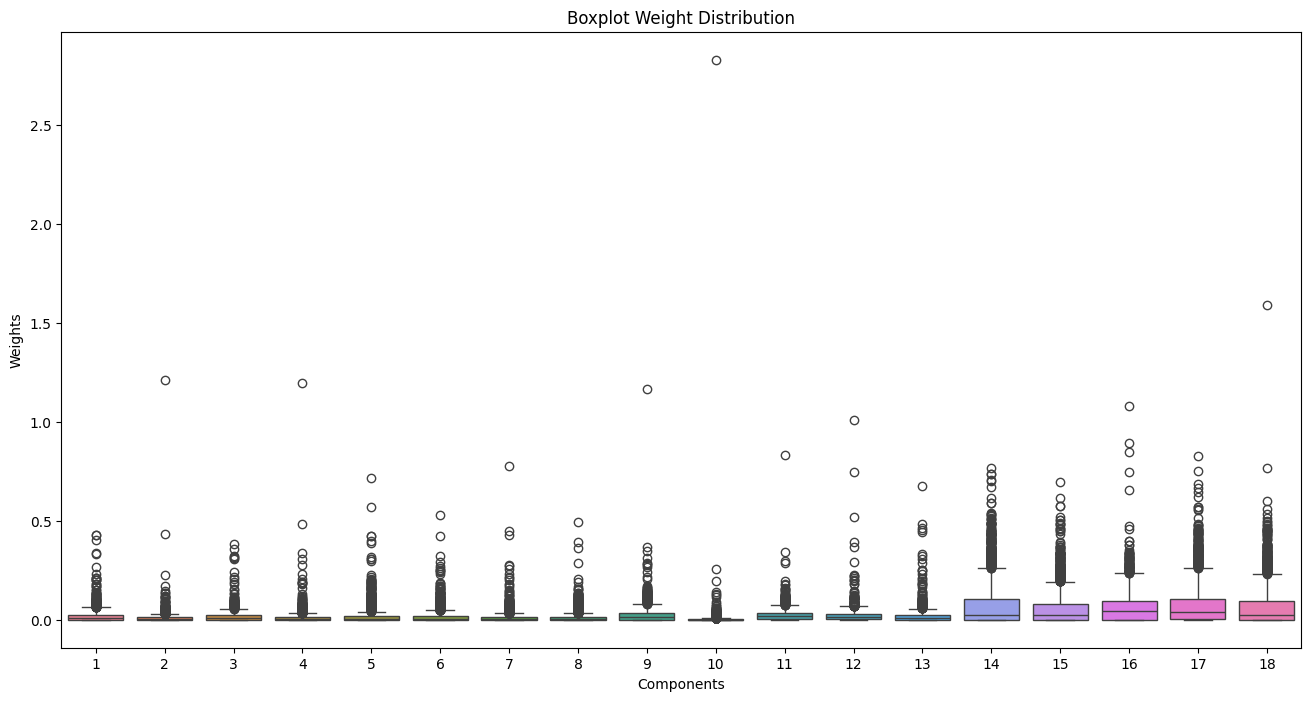

In [7]:
weights = [player_vector for id, player_vector in PVs.player_vectors.items() if len(player_vector) == 18 and id in playersID_to_name]
data = pd.DataFrame(weights, columns=[n for n in range(1, 19)])

plt.figure(figsize=(16, 8))
plt.title('Boxplot Weight Distribution')
sns.boxplot(data=data)
plt.xlabel('Components')
plt.ylabel('Weights')
plt.show()

## Selecting Players



In [8]:
selected_players = [14817,       # Robert Lewandowski,   Postion: Center forward
                    3322,        # Christiano Ronaldo,   Postion: Center forward
                    370,         # Virgil van Dijk,      Postion: Center back
                    3306,        # Sergio Ramos,         Position: Center back
                    38021,       # Kevin De Bruyne       Position: Central midfielder
                    130]         # Stefan de Vrij        Position: Central/right back

## Weights of the 18 Component Player Vectors

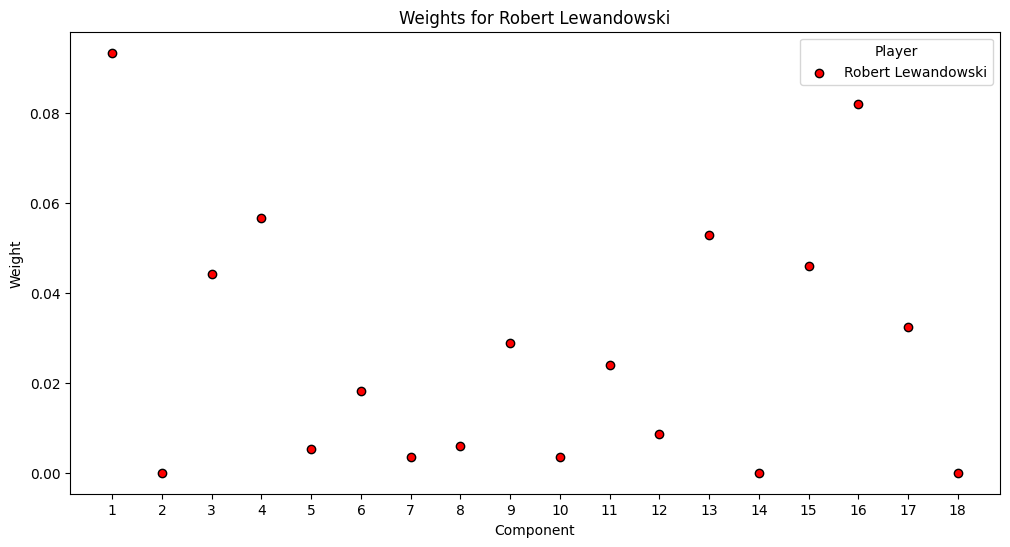

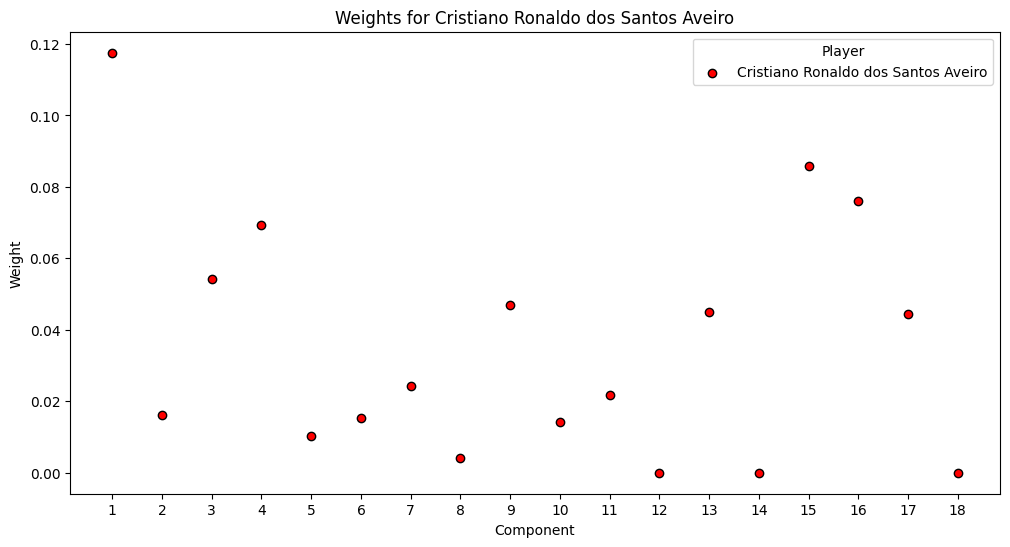

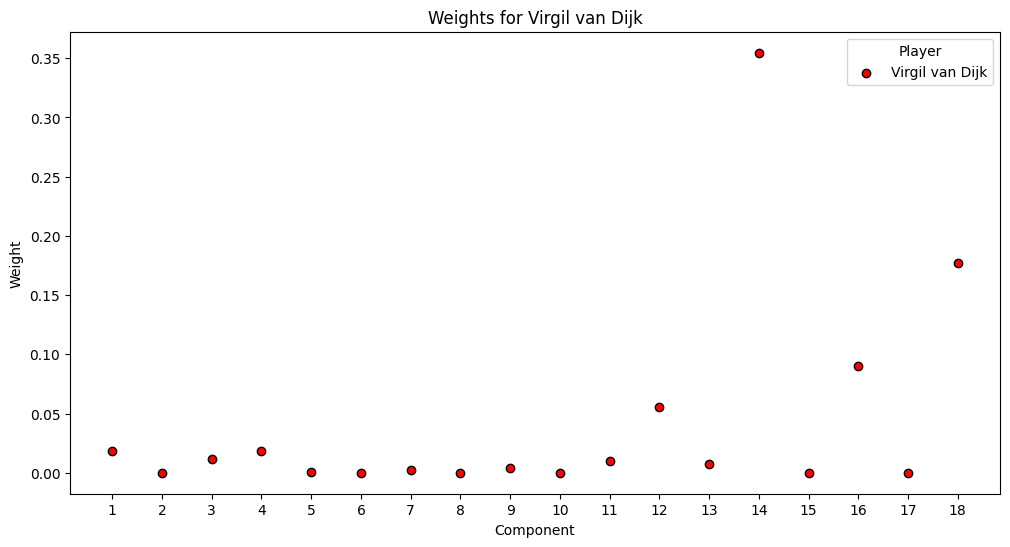

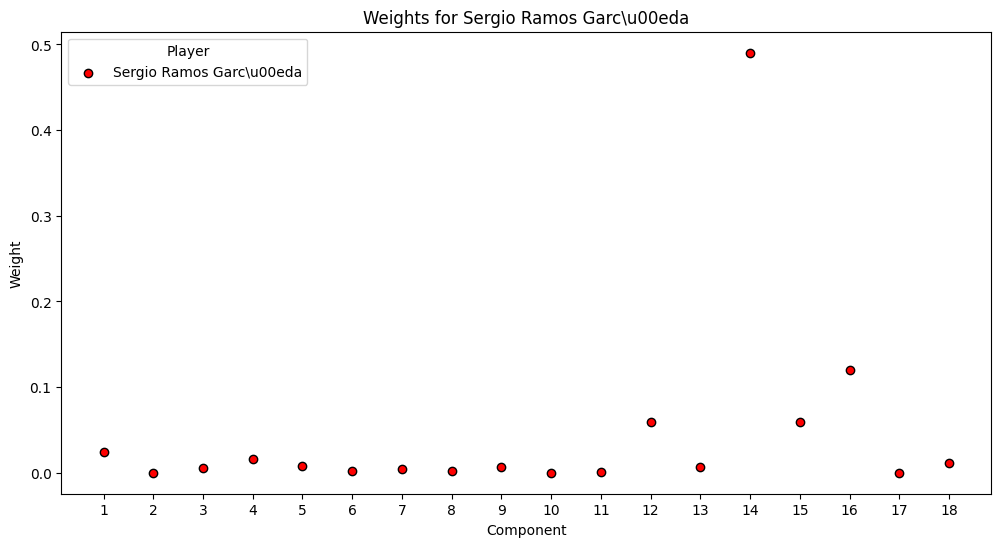

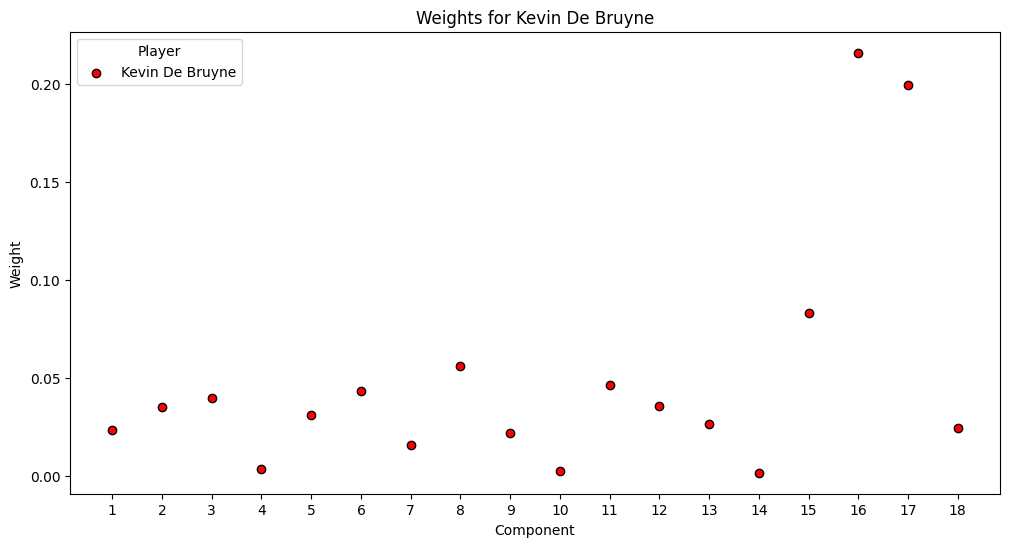

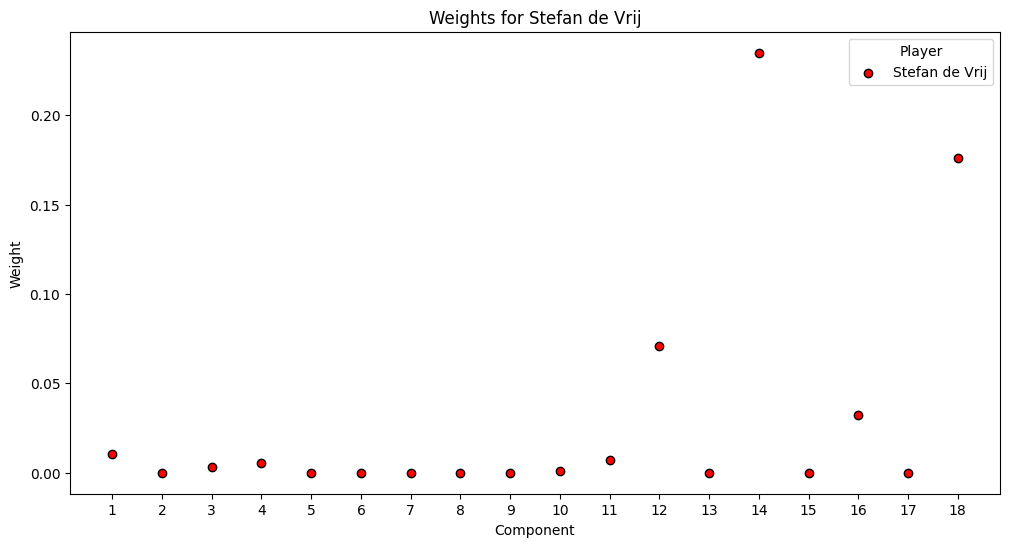

In [9]:
# Define the range of principal components
k_components = list(range(1, 19))

# Some plotting
for player_id in selected_players:
    player_name = playersID_to_name.get(player_id, '')
    player_vector = PVs.player_vectors[player_id] 

    # Ensure the component values contain the expected number of elements
    plt.figure(figsize=(12, 6))  # Set figure size for better visualization
    plt.xlabel('Component')
    plt.ylabel('Weight')

    # Scatter plot of component weights for the player
    plt.scatter(
        k_components, 
        player_vector, 
        color='red', 
        edgecolors='black', 
        label=player_name
    )
    plt.xticks(k_components)  # Set x-axis ticks for clarity
    plt.legend(title="Player")  # Add a legend with a title
    plt.title(f'Weights for {player_name}')  # Add a plot title

plt.show()